In [1]:
# Load Some Packages
import numpy as np
import imageio
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, ntpath

In [2]:
# Given Some Coefficients in Partial(K)/Partial(t)
D = 0.75

# Given Some Coefficients in F(K)
A = -0.3
Kr = 0.03
Ktheta = 0.2
Km = 1.0
r = 8

# Given Some Coefficients in Partial(r)/Partial(t)
B = 0.0001
C = 10.0

In [3]:
# Timesteps
maxIter = 2000

# Given the range of the rectangle
lenX = 200
lenY = 200

deltaX = 0.1
deltaY = 0.1
deltaT = (deltaX*deltaY)**2/(deltaX**2 + deltaY**2)/2/D
D*deltaT

0.0025000000000000005

In [4]:
# Given Initial values
k_init = np.full([lenX, lenY], Kr, dtype=np.float64)
kt_init = np.zeros([lenX, lenY], dtype=np.float64)
r_init = np.zeros([lenX, lenY], dtype=np.float64)
rt_init = np.zeros([lenX, lenY], dtype=np.float64)

In [5]:
# Definie the filter of the laplacian operator
filter_laplacian = np.array([[1/deltaX/deltaY, 1/deltaY**2, 1/deltaX/deltaY],
                           [1/deltaX**2, -4/deltaX/deltaY - 2/deltaX**2 - 2/deltaY**2, 1/deltaX**2],
                           [1/deltaX/deltaY, 1/deltaY**2, 1/deltaX/deltaY]])

filter_laplacian = np.array([[0, 1/deltaY**2, 0],
                           [1/deltaX**2, - 2/deltaX**2 - 2/deltaY**2, 1/deltaX**2],
                           [0, 1/deltaY**2, 0]])

filter_laplacian

array([[   0.,  100.,    0.],
       [ 100., -400.,  100.],
       [   0.,  100.,    0.]])

In [6]:
def Dirichlet_bd( maxIter, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right):
    
    center_point_loc = np.zeros((2,1))
    center_point_loc[0,0] = int(lenX/2)
    center_point_loc[1,0] = int(lenY/2)
    center_point_value = np.zeros([maxIter, 2])
    R_value = np.zeros([maxIter, 2])
    
    # Fixed the boundary values
    K[:,0] = left
    K[:,-1] = right
    K[0,:] = top
    K[-1,:] = bottom
    
    for i in range(maxIter):
        
        if i == clamping_ticks:  
            r2 = r**2
            for a in range(lenX):
                for b in range(lenY):
                    dis2 = (a-center_point_loc[0,0])**2 + (b-center_point_loc[1,0])**2
                    if dis2 < r2:
                        K[a,b] = Km
            

        # Fick's second law
        R = R + deltaT*Rt
        Kt = D*sp.signal.convolve2d(K, filter_laplacian, mode = 'same', boundary='symm') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt

        # Fixed the boundary values
        K[:,0] = left
        K[:,-1] = right
        K[0,:] = top
        K[-1,:] = bottom

        # plot the images
        plt.imsave('./images/{}.png'.format(i), K, cmap = 'hot')
#         plt.imsave('./images/{}.png'.format(i), K, cmap = 'hot', vmin = 0, vmax = 1)
        
#         im_K = K
#         im_K[0,0] = 1
#         im_K[lenX-1, lenY-1] = 0
#         plt.imsave('./images/{}.png'.format(i), im_K, cmap = 'hot')
        
#         fig, ax = plt.subplots()
#         cax = fig.add_axes()

#         if i < clamping_ticks:
            
#             im_K = K
#             im_K[0,0] = 1
#             im_K[lenX-1, lenY-1] = 0
#             im = ax.imshow(im_K, cmap='hot')
#             fig.colorbar(im, cax=cax, orientation='vertical')
#             plt.savefig('./images/{}.png'.format(i))
            
#         else:
#             im = ax.imshow(K, cmap='hot')
#             fig.colorbar(im, cax=cax, orientation='vertical')
#             plt.savefig('./images/{}.png'.format(i))

        # Fick's second law
        Rt = B*((K-Kr) - C*R)
        
        center_point_value[i,0] = i
        center_point_value[i,1] = K[int(center_point_loc[0,0]),int(center_point_loc[1,0])]
        R_value[i,0] = i
        R_value[i,1] = R[int(center_point_loc[0,0]),int(center_point_loc[1,0])]
        
    return center_point_value, R_value

In [7]:
def Neumann_bd( maxIter, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right):
    
    center_point_loc = np.zeros((2,1))
    center_point_loc[0,0] = int(lenX/2)
    center_point_loc[1,0] = int(lenY/2)
    center_point_value = np.zeros([maxIter, 2])
    R_value = np.zeros([maxIter, 2])
    
    
    for i in range(maxIter):

        if i == clamping_ticks:  
            r2 = r**2
            for a in range(lenX):
                for b in range(lenY):
                    dis2 = (a-center_point_loc[0,0])**2 + (b-center_point_loc[1,0])**2
                    if dis2 < r2:
                        K[a,b] = Km
        
        # Fick's second law
        R = R + deltaT*Rt

        Kt = sp.signal.convolve2d(K, filter_laplacian, mode = 'same')
        
        # Fixed the differential boundary values
        Kt[:,0] = left
        Kt[:,-1] = right
        Kt[0,:] = top
        Kt[-1,:] = bottom
        
        Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt
        
        # plot the images
#         plt.imsave('./images/{}.png'.format(i), K, cmap = 'hot')
        plt.imsave('./images/{}.png'.format(i), K, cmap='hot', vmin = 0, vmax = 1)
        
#         fig, ax = plt.subplots()
#         cax = fig.add_axes()

#         if i < clamping_ticks:
            
#             im_K = K
#             im_K[0,0] = 1
#             im_K[lenX-1, lenY-1] = 0
#             im = ax.imshow(im_K, cmap='hot')
#             fig.colorbar(im, cax=cax, orientation='vertical')
#             plt.savefig('./images/{}.png'.format(i))
            
#         else:
#             im = ax.imshow(K, cmap='hot')
#             fig.colorbar(im, cax=cax, orientation='vertical')
#             plt.savefig('./images/{}.png'.format(i))

        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        center_point_value[i,0] = i
        center_point_value[i,1] = K[int(center_point_loc[0,0]),int(center_point_loc[1,0])]
        R_value[i,0] = i
        R_value[i,1] = R[int(center_point_loc[0,0]),int(center_point_loc[1,0])]
        
    return center_point_value, R_value

In [8]:
def Periodic_bd( maxIter, clamping_ticks, K, Kt, R, Rt):

    center_point_loc = np.zeros((2,1))
    center_point_loc[0,0] = int(lenX/2)
    center_point_loc[1,0] = int(lenY/2)
    center_point_value = np.zeros([maxIter, 2])
    R_value = np.zeros([maxIter, 2])
    
    
    for i in range(maxIter):

        if i == clamping_ticks:  
            r2 = r**2
            for a in range(lenX):
                for b in range(lenY):
                    dis2 = (a-center_point_loc[0,0])**2 + (b-center_point_loc[1,0])**2
                    if dis2 < r2:
                        K[a,b] = Km
        
        # Fick's second law
        R = R + deltaT*Rt
        Kt = D*sp.signal.convolve2d(K, filter_laplacian, mode = 'same', boundary = 'wrap') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt
        
        # plot the images
#         plt.imsave('./images/{}.png'.format(i), K, cmap='hot')
        plt.imsave('./images/{}.png'.format(i), K, cmap = 'hot', vmin = 0, vmax = 1)

#         fig, ax = plt.subplots()
#         cax = fig.add_axes()

#         if i < clamping_ticks:
            
#             im_K = K
#             im_K[0,0] = 1
#             im_K[lenX-1, lenY-1] = 0
#             im = ax.imshow(im_K, cmap='hot')
#             fig.colorbar(im, cax=cax, orientation='vertical')
#             plt.savefig('./images/{}.png'.format(i))
            
#         else:
#             im = ax.imshow(K, cmap='hot')
#             fig.colorbar(im, cax=cax, orientation='vertical')
#             plt.savefig('./images/{}.png'.format(i))

        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        center_point_value[i,0] = i
        center_point_value[i,1] = K[int(center_point_loc[0,0]),int(center_point_loc[1,0])]
        R_value[i,0] = i
        R_value[i,1] = R[int(center_point_loc[0,0]),int(center_point_loc[1,0])]
        
    return center_point_value, R_value

In [9]:
def compute_fick_law(boundary, clamping_ticks = 100, top = 0.0, bottom = 0.0, left = 0.0, right = 0.0):
    '''N: The number of the random points you want to pick'''
    '''clamping_ticks: '''
    
    # remove other images in the dir
    for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
        os.remove(image)
    
    # Fixed the initial values
    K = k_init
    Kt = kt_init
    R = r_init
    Rt = rt_init
    
    if boundary == 'Diri':
        point_value, R_value = Dirichlet_bd( maxIter, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right)
        
    elif boundary == 'Neum':
        point_value, R_value = Neumann_bd( maxIter, clamping_ticks, K, Kt, R, Rt, top, bottom, left, right)
        
    elif boundary == 'Perid':
        point_value, R_value = Periodic_bd( maxIter, clamping_ticks, K, Kt, R, Rt)
        
    return point_value, R_value

In [10]:
# Diri, Neum, Perid
point_value, R_value = compute_fick_law('Diri', clamping_ticks = 200, top = Kr, bottom = Kr, left = Kr, right = Kr)
# point_value, R_value = compute_fick_law('Neum', clamping_ticks = 200)
# point_value, R_value = compute_fick_law('Perid', clamping_ticks = 200)

In [11]:
# load all timesteps images
images = []
for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
    images.append(imageio.imread(image))
    

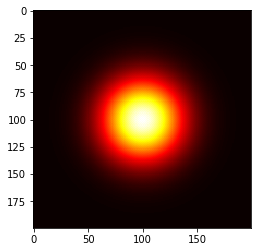

In [12]:
plt.imshow(images[1500])

In [ ]:
def make_video(images, image_folder, video_name, outimg=None, fps=5, size=None,
               is_color=True, format="XVID"):
    
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.join(image_folder, image):
            raise FileNotFoundError(image)
        img = imread(os.path.join(image_folder, image))
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(video_name, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

In [ ]:
image_folder = 'images'
video_name = 'Diffusion.mp4'

images = []
for i in range(maxIter):
    images.append( str(int(i)) + ".png")

make_video(images, image_folder, video_name, outimg=None, fps=50*int(1/deltaT), size=None, is_color=True, format="XVID")

In [ ]:
N = 1000
K_R_value = np.zeros((N,2))
K_R_value[:,0] = point_value[:N,1]
K_R_value[:,1] = R_value[:N,1]
plt.plot( K_R_value)

In [ ]:
print(np.max(R_value[:,1]), np.min(R_value[:,1]))
np.argmax(R_value[:,1])

In [ ]:
plt.plot(R_value[:,1])

0 1
50 2
150 3
950 4


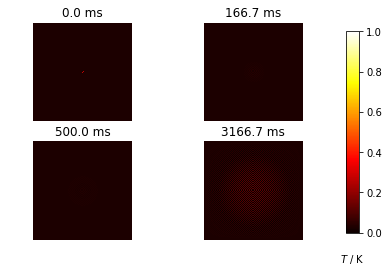

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 0.75

Tcool, Thot = 0., 1.

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

r0 = np.zeros((nx-2, ny-2))
u0 = Kr * np.ones((nx, ny))
u = np.empty((nx, ny))

# Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = 0.02, 5, 5
r2 = r**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot

def do_timestep(u0, u, r0):
    # Propagate with forward-difference in time, central-difference in space
    
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 ) + A*(
        u0[1:-1, 1:-1]-Kr)*(u0[1:-1, 1:-1]-Ktheta)*(u0[1:-1, 1:-1]-Km)*(u0[1:-1, 1:-1]+0.1) - r0*u[1:-1, 1:-1]
    
    u[:,0:2] = Kr
    u[:,ny-2:ny] = Kr
    u[0:2,:] = Kr
    u[nx-2:nx,:] = Kr
    
    r0 = r0 + dt*B*((u0[1:-1, 1:-1] - Kr) - C*r0)

    u0 = u.copy()
    
    return u0, u, r0

# Number of timesteps
nsteps = 1000
# Output 4 figures at these timesteps
mfig = [0, 50, 150, 950]
fignum = 0
fig = plt.figure()
for m in range(nsteps):
    u0, u, r0 = do_timestep(u0, u, r0)
    if m in mfig:
        fignum += 1
        print(m, fignum)
        ax = fig.add_subplot(220 + fignum)
        im = ax.imshow(u.copy(), cmap=plt.get_cmap('hot'), vmin=Tcool,vmax=1)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(m*dt*1000))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()